Validation accuracy: 0.6607584868914971
Test accuracy: 0.6613048293701823
Test precision: 0.3330618965378386
Test recall: 0.6915773239933852
Test F1-score: 0.44959835719031227
Test AUC-ROC score: 0.7374902372284182
Top 15 most predictive features:
                 feature   importance
6                  grade  2208.594971
7              sub_grade  1074.723389
3                   term   160.569962
9         home_ownership    87.893181
43           open_rv_24m    85.460663
45              all_util    72.981323
50  acc_open_past_24mths    66.491135
51           avg_cur_bal    63.836720
8             emp_length    61.145424
60              mort_acc    58.359535
19        fico_range_low    55.557663
67       num_actv_rev_tl    55.284744
75      num_tl_120dpd_2m    49.956165
16                   dti    46.480888
0              loan_amnt    41.379730


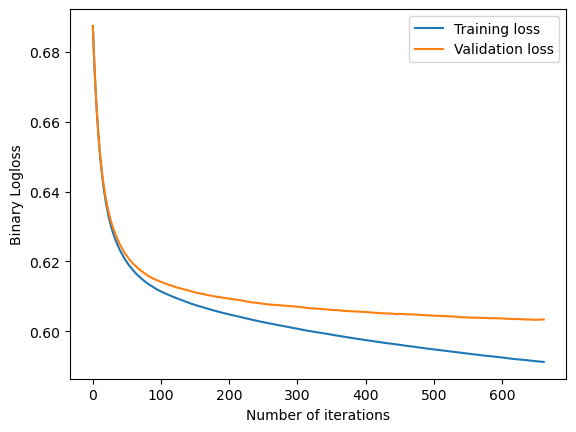

In [1]:
# LOAN DEFAULT PREDICTION USING XGBoost

import sys
import pandas as pd
import numpy as np
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


from imblearn.under_sampling import RandomUnderSampler


# Read the Excel dataset into a pandas DataFrame
data = pd.read_csv('accepted_2007_to_2018Q4.csv', low_memory=False)



def separate_features(dataframe):
    categorical_features = []
    continuous_features = []

    for column in dataframe.columns:
        if dataframe[column].dtype == 'object' or dataframe[column].dtype.name == 'category':
            categorical_features.append(column)
        elif dataframe[column].dtype == 'int64' or dataframe[column].dtype == 'float64':
            continuous_features.append(column)
        else:
            print(f'Unhandled data type in column "{column}": {dataframe[column].dtype}')

    return categorical_features, continuous_features



#print("Categorical Features:", cat_features)
#print("Continuous Features:", cont_features)


data = data[data['loan_status'].isin(['Fully Paid','Charged Off','Defaulted'])]
leakage_features = [
    'out_prncp',
    'out_prncp_inv',
    'total_pymnt',
    'total_pymnt_inv',
    'total_rec_prncp',
    'total_rec_int',
    'total_rec_late_fee',
    'recoveries',
    'collection_recovery_fee',
    'last_pymnt_d',
    'last_pymnt_amnt',
    'next_pymnt_d',
    'last_credit_pull_d',
    'debt_settlement_flag',
    'debt_settlement_flag_date',
    'settlement_status',
    'settlement_date',
    'settlement_amount',
    'settlement_percentage',
    'settlement_term',
    'last_fico_range_high',
    'last_fico_range_low',
    'id',
    'url',
    'emp_title',
    'title'
]

# Drop the leakage features
data = data.drop(leakage_features, axis=1)

# Calculate the percentage of missing values for each feature
missing_values = data.isnull().sum() / len(data) * 100

# Identify columns with more than 90% missing values
columns_to_drop = missing_values[missing_values > 90].index

# Drop the identified columns
data = data.drop(columns_to_drop, axis=1)

categorical_features, continuous_features = separate_features(data)
categorical_features.remove('loan_status')

# fill numeric NAs with median
#median_values = data[continuous_features].median() 
#data[continuous_features] = data[continuous_features].fillna(median_values)
data[continuous_features] = data[continuous_features].fillna(-1)

# Fill categorical NAs with "missing" and convert all elements to strings
data[categorical_features] = data[categorical_features].fillna('missing').astype(str)

data.isna().sum().sum()

#Scaling
#scaler = StandardScaler()
#data[continuous_features] = scaler.fit_transform(data[continuous_features])

for feature in categorical_features:
    label_encoder = LabelEncoder()
    data[feature] = label_encoder.fit_transform(data[feature])

# Preprocess loan status labels with custom encoding
custom_encoding = {
    'Fully Paid': 0,
    'Charged Off': 1,
    'Default': 1,
    
}
data['loan_status'] = data['loan_status'].replace(custom_encoding)


# Split the dataset into features (X) and labels (y)
X = data.drop('loan_status', axis=1)
y = data['loan_status']




# Split the dataset into training and temporary sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)

# Apply RandomUnderSampler to balance the training dataset
undersampler = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

# Split the temporary set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


# Scaling continuous features for the training, validation, and test sets
scaler = StandardScaler()
X_train_resampled[continuous_features] = scaler.fit_transform(X_train_resampled[continuous_features])
X_val[continuous_features] = scaler.transform(X_val[continuous_features])
X_test[continuous_features] = scaler.transform(X_test[continuous_features])


# Create the XGBoost model
params = {
    'objective': 'binary:logistic',
    'booster': 'gbtree',
    'max_depth': 4,
    'learning_rate': 0.05,
    'subsample': 0.9,
    'alpha': 0.01,
    'lambda': 0.01,
    'eval_metric': 'logloss',
}

# Update the train_data and validation_data for the XGBoost model
train_data = xgb.DMatrix(X_train_resampled, label=y_train_resampled)
validation_data = xgb.DMatrix(X_val, label=y_val)

# Train the model
num_rounds = 1000
evals = [(train_data, 'train'), (validation_data, 'valid')]
evals_result = {}
model = xgb.train(params, train_data, num_rounds, evals=evals, early_stopping_rounds=10, verbose_eval=False, evals_result=evals_result)

# Make predictions on the test set
X_test_data = xgb.DMatrix(X_test)
y_pred = model.predict(X_test_data)
y_pred_binary = np.round(y_pred).astype(int)

# Calculate the test accuracy
test_accuracy =accuracy_score(y_test, y_pred_binary)
test_precision = precision_score(y_test, y_pred_binary)
test_recall = recall_score(y_test, y_pred_binary)
test_f1_score = f1_score(y_test, y_pred_binary)
test_auc_roc = roc_auc_score(y_test, y_pred)


# Calculate the validation accuracy
X_val_data = xgb.DMatrix(X_val)
y_pred_val = model.predict(X_val_data)
y_pred_val_binary = np.round(y_pred_val).astype(int)
val_accuracy = accuracy_score(y_val, y_pred_val_binary)

# Compare the validation accuracy and test accuracy
print(f"Validation accuracy: {val_accuracy}")
print(f"Test accuracy: {test_accuracy}")
print(f"Test precision: {test_precision}")
print(f"Test recall: {test_recall}")
print(f"Test F1-score: {test_f1_score}")
print(f"Test AUC-ROC score: {test_auc_roc}")

# Get feature importances
importance = model.get_score(importance_type='gain')

# Create a DataFrame for feature names and their corresponding importance scores
feature_importance_df = pd.DataFrame({'feature': list(importance.keys()), 'importance': list(importance.values())})

# Sort the DataFrame by the importance score in descending order
sorted_feature_importance = feature_importance_df.sort_values(by='importance', ascending=False)

# Display the top 5 most predictive features
print("Top 15 most predictive features:")
print(sorted_feature_importance.head(15))

# Plot the learning curves
import matplotlib.pyplot as plt

# Extract the binary logloss values for training and validation sets
train_loss = evals_result['train']['logloss']
valid_loss = evals_result['valid']['logloss']

# Create a plot with training and validation loss curves
plt.plot(train_loss, label='Training loss')
plt.plot(valid_loss, label='Validation loss')
plt.xlabel('Number of iterations')
plt.ylabel('Binary Logloss')
plt.legend()
plt.show()